In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import netCDF4 as netCDF
# from datetime import timedelta, datetime
import tracpy
import op
import tracpy.plotting
import glob
import time_res
from matplotlib import rc, ticker, cm
import pandas as pd
from scipy.optimize import curve_fit
import pdb
import pylab as P
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pandas as pd

# from lmfit import minimize, Parameters, Parameter, report_fit
units = 'seconds since 1970-01-01'
matplotlib.rcParams.update({'font.size': 24})
mpl.rcParams['font.sans-serif'] = 'Arev Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.cal'] = 'cursive'
mpl.rcParams['mathtext.rm'] = 'sans'
mpl.rcParams['mathtext.tt'] = 'monospace'
mpl.rcParams['mathtext.it'] = 'sans:italic'
mpl.rcParams['mathtext.bf'] = 'sans:bold'
mpl.rcParams['mathtext.sf'] = 'sans'
mpl.rcParams['mathtext.fallback_to_cm'] = 'True'


/Users/kthyng/.virtualenvs/default/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#Time resolution for model output

Want to compare the trajectory of drifters run with different model output frequencies. Ping's group's Gulf of Mexico model has output every 5 minutes and has run drifters online, the control case. I will run simulations with output from 5 minutes to less frequent output and also less frequent output with linear interpolations between.

The last day of each three day simulation was linearly combined with the first day of the subsequent three day simulation, such that the weighting linearly moved from primarily on the previous simulation to the subsequent simulation. This helps to mitigate the initialization period at the beginning of the new simulation and put less emphasis on the older simulation, which drifts with time.

The sea surface height was not saved at 5 minute intervals, so I treated it uniformly as a flat boundary and it should affect all of the drifters equally, which is ok since this is a relative test between drifter simulations.

Drifters are being initialized in the area coinciding with the SCULP1 drifter data and are only run from these locations for now. Each set of drifters is 7200 drifters.

See init.py and dispersion.py for simulation details. Plots will be made here. Simulation information is on hafen and on the external drive Emmons.

In [3]:
mins = np.array([5,10,20,30,45,60,2*60,3*60,4*60,6*60]) # number of minutes for different simulations
col = np.linspace(0.1,0.8,6*60+1) # linspace from 0 to 6 hours' worth of minutes to divide up the grey space
cols = col[mins] # pick out grey values for coloring lines
cols = [str(value) for value in cols] # make colors into strings
ms = ['-','--','-.',':','-','--','-.',':','-','--','-.',':'] # marker styles for each simulation

grid_filename = 'ocean_his_2010-07-01_00.nc'
currents_filename = 'ocean_his_0001.nc'
vert_filename = 'ocean_his_0001.nc'
loc = ['ocean_his_0001.nc', 'ocean_his_2010-07-01_00.nc']
dx = 3. # grid size in kilometers
dxm = 3000. # grid size in meters
ndays=3

In [4]:
# For original case:
d_orig = load('/Volumes/Emmons/projects/time_res/calcs/uv_orig.npz')
u_orig = d_orig['u']; v_orig = d_orig['v']
t = d_orig['t']
d_orig.close()
tind = find((t-t[0])/(3600*24.)==ndays)
dt = (t[1]-t[0])

# Test Case
d_test = load('/Volumes/Emmons/projects/time_res/calcs/uv_test.npz')
u_test = d_test['u']; v_test = d_test['v']
d_test.close()

# 4th case area
d_4th = load('/Volumes/Emmons/projects/time_res/calcs/uv_4th.npz')
u_4th = d_4th['u']; v_4th = d_4th['v']
t = d_4th['t']
d_4th.close()

T = mins*60.
tstride = T/dt
tau = ndays*3600.*24 # simulation time [s]
N = tau/T # number of samples []
n = tstride.copy() # otherwise i am going to confuse myself
nsteps = int(round(n[0]))*int(N[0]) # same for all since all output at 5min

days = (t-t[0])/(3600*24)

## Velocity Spectra

Below shows an example velocity signal from each test area in time and in frequency space to show the relative magnitudes of the signals at different frequencies.

/Users/kthyng/.virtualenvs/default/lib/python2.7/site-packages/matplotlib/mathtext.py:868: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


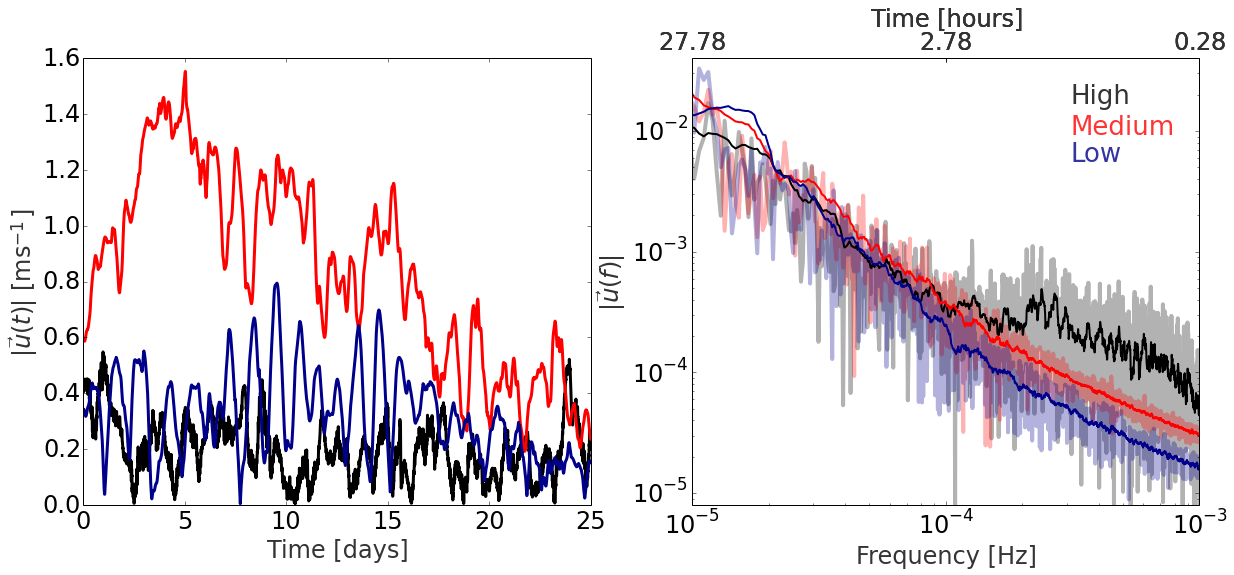

In [5]:
# http://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
nndays = 25
nind = find(days==nndays)

def tick_function(X):
    temp = [(1./z)/(3600.) for z in X] # in hours
    temp = ["%.2f" % z for z in temp]
    temp = ['$' + z + '$' for z in temp]
    return temp

def plotSpectrum(y, Fs, col, alph):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = len(y) # length of the signal
    k = arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range
    
    Y = fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n/2)]
    
    ax1.loglog(frq,abs(Y), col, linewidth=4, alpha=alph) # plotting the spectrum
    
    ax1.set_xlabel('Frequency [Hz]', color='0.2')
    ax1.set_ylabel(r'$|\vec{u}(f)|$', color='0.2')
    locs_save = ax1.get_xticks()
    ax2 = ax1.twiny()
    ax2.set_xticks(np.linspace(0,1,3)[0:]) # change the 6 to match the number of ticks on the bottom
    ax2.set_xticklabels(tick_function(locs_save[3:-2]), color='.2')#, fontsize=26)
    ax2.set_xlabel('Time [hours]', color='0.2')#, fontsize=28)
    return frq, abs(Y)

Fs = 1/dt;  # sampling rate
Ts = dt; # sampling interval

fig = figure(figsize=(20,8))
fig.add_subplot(1,2,1)
plot(days[:nind], sqrt(u_orig[:nind,24,28]**2+v_orig[:nind,24,28]**2), 'k', linewidth=3)#, alpha=.8) 
plot(days[:nind], sqrt(u_test[:nind,24,28]**2+v_test[:nind,24,28]**2), 'r', linewidth=3)#, alpha=.8)
plot(days[:nind], sqrt(u_4th[:nind,24,28]**2+v_4th[:nind,24,28]**2), color='darkblue', linewidth=3)#, alpha=.8)
xlabel('Time [days]', color='0.2')
ylabel(r'$|\vec{u}(t)|$ [ms$^{-1}]$', color='0.2')
ax1 = fig.add_subplot(1,2,2)
frq, Y = plotSpectrum(sqrt(u_orig[:nind,24,28]**2+v_orig[:nind,24,28]**2), Fs, 'k', .3)    
ts_orig = pd.Series(Y)#, index=date_range('1/1/2000', periods=1000))
    
frq, Y = plotSpectrum(sqrt(u_test[:nind,24,28]**2+v_test[:nind,24,28]**2), Fs, 'r', .3)
ts_test = pd.Series(Y)#, index=date_range('1/1/2000', periods=1000))

frq, Y = plotSpectrum(sqrt(u_4th[:nind,24,28]**2+v_4th[:nind,24,28]**2), Fs, 'darkblue', .3)#'.4', .6)
ts_4th = pd.Series(Y)#, index=date_range('1/1/2000', periods=1000))

ax1.plot(frq, pd.rolling_mean(ts_orig, 20), color='k', lw=2)
ax1.plot(frq, pd.rolling_mean(ts_test, 20), color='r', lw=2)
ax1.plot(frq, pd.rolling_mean(ts_4th, 20), color='darkblue', lw=2)

# Find magnitude of signal near sampling frequencies
U_orig = np.zeros(T.size) # magnitude of signal in freq space
U_test = np.zeros(T.size) # magnitude of signal in freq space
U_4th = np.zeros(T.size) # magnitude of signal in freq space
for i in xrange(T.size):
    if i==0 or i==1:
        continue
    frqind = find(frq>=1./T[i])[0]
    U_orig[i] = pd.rolling_mean(ts_orig, 20)[frqind]
    U_test[i] = pd.rolling_mean(ts_test, 20)[frqind]
    U_4th[i] = pd.rolling_mean(ts_4th, 20)[frqind]

ax1.set_xlim(1e-5,.1e-2)
ax1.set_ylim(8e-6,4e-2)

ax = gca()
text(0.75, 0.9, 'High', color='k', transform=ax.transAxes, alpha=0.8, fontsize=26)
text(0.75, 0.83, 'Medium', color='r', transform=ax.transAxes, alpha=0.8, fontsize=26)
text(0.75, 0.77, 'Low', color='darkblue', transform=ax.transAxes, alpha=0.8, fontsize=26)
savefig('figures/spectra' + str(nndays) + '.pdf', bbox_inches='tight')
savefig('figures/spectra' + str(nndays) + '.png', bbox_inches='tight', dpi=300)

## Example Subsampling

Below shows a simplified example of a velocity signal at high, medium, and low temporal resolution, which is linearly interpolated between subsamples for stepping drifters.

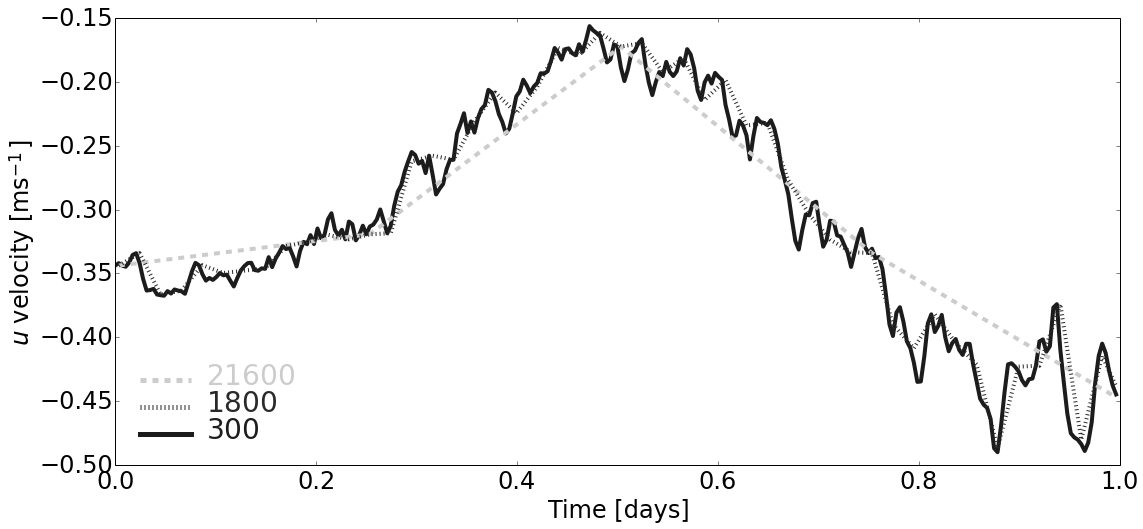

In [6]:
# Plot what it looks like to only linearly interpolate between model outputs (this ignores the short time periods over which
# the output is assumed to be steady).

# Plot highest resolution information available
iyo = 24; ixo = 28;
tindtemp = find(days==1)
ninds = len(days[:tindtemp])
figure(figsize=(18,8))
plot(days[:tindtemp], u_orig[:tindtemp,iyo,ixo], color=cols[0], linestyle=ms[0], linewidth=4)

# Plot a low resolution case (6 hours)
k = 9
ntemp = int(round(n[k]))
i0 = 0; iT = ntemp; # initial time indices for the end points of a sampling period comparison
utemp = np.ones(ninds)*np.nan # initialize interpolation velocities
for i in xrange(1,ninds): # loop through all steps for simulation comparison
    utemp[i] = (ntemp-(i-1)+i0)/float(ntemp)*u_orig[i0,iyo,ixo] + (i-1-i0)/float(ntemp)*u_orig[iT,iyo,ixo]
    if mod(i,ntemp)==0:
        i0 = iT; iT = iT + ntemp
plot(days[:tindtemp], utemp, color=cols[k], linewidth=4, linestyle=ms[k])

# Plot a medium resolution case (30 minutes)
k = 3
ntemp = int(round(n[k]))
i0 = 0; iT = ntemp; # initial time indices for the end points of a sampling period comparison
utemp = np.ones(ninds)*np.nan # initialize interpolation velocities
for i in xrange(1,ninds): # loop through all steps for simulation comparison
    utemp[i] = (ntemp-(i-1)+i0)/float(ntemp)*u_orig[i0,iyo,ixo] + (i-1-i0)/float(ntemp)*u_orig[iT,iyo,ixo]
    if mod(i,ntemp)==0:
        i0 = iT; iT = iT + ntemp
plot(days[:tindtemp], utemp, color=cols[k], linewidth=4, linestyle=ms[k])

xlabel('Time [days]')
ylabel(r'$u$ velocity [ms$^{-1}$]')

# legend
ks = [0,3,9]
ax = gca()
for i, value in enumerate(T[ks]):
    text(0.09, 0.0+0.06*(i+1), '$' + "%.0f" % value + '$', color=cols[ks[i]], transform = ax.transAxes, fontsize=28, family='monospace')
    plot([0.025, 0.075], [0.01+0.06*(i+1), 0.01+0.06*(i+1)], linestyle=ms[ks[i]], color=cols[ks[i]], 
         linewidth=5, transform = ax.transAxes)
    
savefig('figures/sample_velocity.pdf', bbox_inches='tight')


This plot shows a simplification of the difference in model output that is used by TRACMASS based on samping output period.

## Overall and sample trajectories

In [7]:
llcrnrlon=-97.944923400878906; urcrnrlon=-79.164894104003906;
llcrnrlat=18.132225036621094; urcrnrlat=30.847625732421861
# New input method to TracPy
grid = tracpy.inout.readgrid(grid_filename, vert_filename=vert_filename, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon,
                                  llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, usebasemap=True)  # grid file, Gulf model domain
# grid = tracpy.inout.readgrid(loc, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon,
#                                   llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat)  # grid file, Gulf model domain

theta_s not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4


Examples, with high resolution info

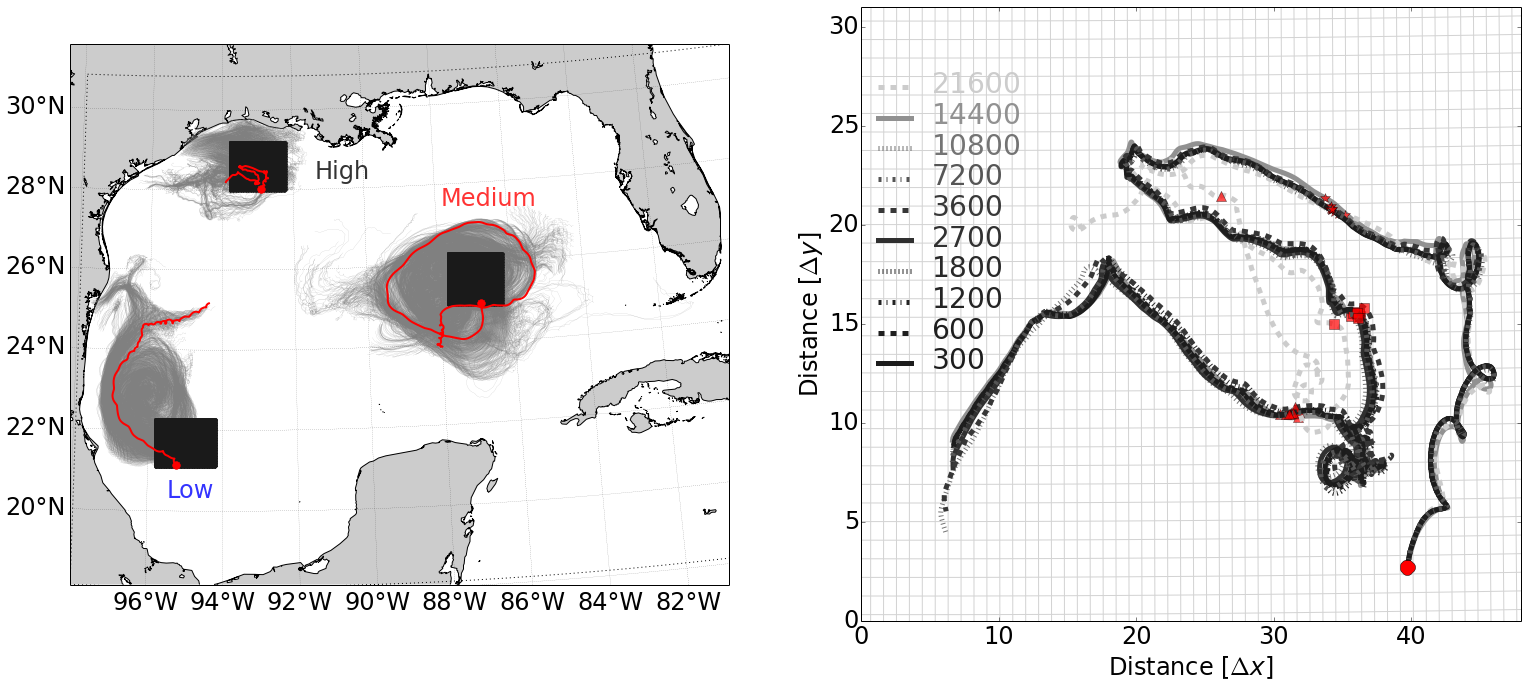

In [8]:
matplotlib.rcParams.update({'font.size': 24})

# An example drifter to show for each case
ix = 200; dx = 3000.; xint = 138; yint = 365;

fig = figure(figsize=(26,11))
# Plot overview on left and zoom in on right:
# Plot all tracks in light grey and starting positions in dark grey on top.
ax1 = fig.add_subplot(1,2,1)
tracpy.plotting.background(grid=grid, pars=np.arange(18, 35, 2), mers=np.arange(-100, -80, 2), hlevs=np.arange(0,500,500))

# Original or High case: high res
File = '/Volumes/Emmons/projects/time_res/tracks/test/tseas_use300_nsteps1.nc'
d = netCDF.Dataset(File)
xp, yp = grid['basemap'](d.variables['lonp'][:], d.variables['latp'][:])
d.close()
plot(xp[::5,:].T, yp[::5,:].T, '-', color='grey', linewidth=0.1)
plot(xp[:,0].T, yp[:,0].T, '.', color='.1', mec='.1')
plot(xp[ix,:].T, yp[ix,:].T, '-', color='r', linewidth=2)
plot(xp[ix,0].T, yp[ix,0].T, '.', color='r', markersize=15)

# 4th or Low case: high res
File = '/Volumes/Emmons/projects/time_res/tracks/4th/tseas_use300_nsteps1.nc'
d = netCDF.Dataset(File)
xp, yp = grid['basemap'](d.variables['lonp'][:], d.variables['latp'][:])
d.close()
plot(xp[::5,:].T, yp[::5,:].T, '-', color='grey', linewidth=0.1)
plot(xp[:,0].T, yp[:,0].T, '.', color='.1', mec='.1')
plot(xp[ix,:].T, yp[ix,:].T, '-', color='r', linewidth=2)
plot(xp[ix,0].T, yp[ix,0].T, '.', color='r', markersize=15)

# Test or Medium case: high res
File = '/Volumes/Emmons/projects/time_res/tracks/tseas_use300_nsteps1.nc'
d = netCDF.Dataset(File)
xp, yp = grid['basemap'](d.variables['lonp'][:], d.variables['latp'][:])
d.close()
plot(xp[::5,:].T, yp[::5,:].T, '-', color='grey', linewidth=0.1)
plot(xp[:,0].T, yp[:,0].T, '.', color='.1', mec='.1')
plot(xp[ix,:].T, yp[ix,:].T, '-', color='r', linewidth=2)
plot(xp[ix,0].T, yp[ix,0].T, '.', color='r', markersize=15)

# Add test for labels
text(0.375, 0.75, 'High', color='k', transform=ax1.transAxes, alpha=0.8)
text(0.565, 0.7, 'Medium', color='r', transform=ax1.transAxes, alpha=0.8)
text(0.15, 0.16, 'Low', color='b', transform=ax1.transAxes, alpha=0.8)

ax2 = fig.add_subplot(1,2,2)
plot(grid['xr']/dx - xint, grid['yr']/dx - yint, 'lightgrey', grid['xr'].T/dx - xint, grid['yr'].T/dx - yint, 'lightgrey')
Files = glob.glob('/Volumes/Emmons/projects/time_res/tracks/*.nc')
for i, File in enumerate(Files):
    
    if 'gc' in File or '28800' in File or '36000' in File:
        continue
    
    d = netCDF.Dataset(File)
    xp, yp = grid['basemap'](d.variables['lonp'][ix,:], d.variables['latp'][ix,:])
    tp = d.variables['tp'][:]
    dt = (tp[1]-tp[0])/(3600.*24) # dt in days
    t = (tp-tp[0])/(3600.*24) # time vector in days
    tind1 = find(t==7) # this is for plotting on the tracks every week
    tind2 = find(t==14) # this is for plotting on the tracks every week
    tind3 = find(t==21) # this is for plotting on the tracks every week
    xp = xp/dx; yp = yp/dx; # Normalize by grid size
    tseas = float(File.split('tseas_use')[1].split('_')[0])/60. # model output sampling time in minutes
    cind = find(mins==tseas) # find index in plotting arrays for this simulation
    # Plot lines
    plot(xp - xint, yp - yint, color=cols[cind], linestyle=ms[cind], linewidth=5)
    # Place number every week
    plot(xp[tind1] - xint, yp[tind1] - yint, 'r', marker='*', markersize=10, linestyle='', alpha=0.7)#color=col, linestyle=m, linewidth=3, markersize=10)
    plot(xp[tind2] - xint, yp[tind2] - yint, 'r', marker='s', markersize=10, linestyle='', alpha=0.7)#color=col, linestyle=m, linewidth=3, markersize=10)
    plot(xp[tind3] - xint, yp[tind3] - yint, 'r', marker='^', markersize=10, linestyle='', alpha=0.7)#color=col, linestyle=m, linewidth=3, markersize=10)
    d.close()

ax2.set_xlabel('Distance [$\Delta x$]')
ax2.set_ylabel('Distance [$\Delta y$]')

# Plot starting point
plot(xp[0] - xint, yp[0] - yint, 'or', markersize=15)
xlim(0, 48); ylim(0, 31);

# legend
# http://matplotlib.org/users/recipes.html
props = dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='white')
for i, value in enumerate(T):
    text(0.105, 0.36+0.05*(i+1), '$' + "%.0f" % value + '$', color=cols[i], transform = ax2.transAxes, fontsize=28, family='monospace')
    plot([0.025, 0.075], [0.37+0.05*(i+1), 0.37+0.05*(i+1)], linestyle=ms[i], color=cols[i], 
         linewidth=5, transform = ax2.transAxes)
    
savefig('figures/trajectories.png', bbox_inches='tight', dpi=300)


Left: Grey lines show aggregated drifter tracks and dark grey shows the grid of their initial positions.
Right: A sample drifter starting location is shown in red along with 25-day tracks for model output at different temporal resolutions, whose tracks are shown as different grey scales and line styles. Small red stars indicate a week of time for reference between tracks.

The tracks are relatively similar for the first week, then the 8-hour track deviates significantly. The other tracks stay relatively aligned with the high resolution tracks, though the 6 and 4 hour tracks do deviate still. With time interpolation, the tracks may be improved and align better with the higher resolution output.

## Separation Distances in Time

This metric captures the numerical error in terms of separation distance between drifters started in subsampled output in time as compared with the base case of 5 minute output. Using the not squared version of this measure makes it easier to interpret in terms of distance.

In [9]:
FilesC_orig = ['/Volumes/Emmons/projects/time_res/calcs/tseas_use300_nsteps1.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use600_nsteps2.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use1200_nsteps4.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use1800_nsteps6.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use2700_nsteps9.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use3600_nsteps12.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use7200_nsteps24.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use10800_nsteps36.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use14400_nsteps48.nc',
         '/Volumes/Emmons/projects/time_res/calcs/tseas_use21600_nsteps72.nc']

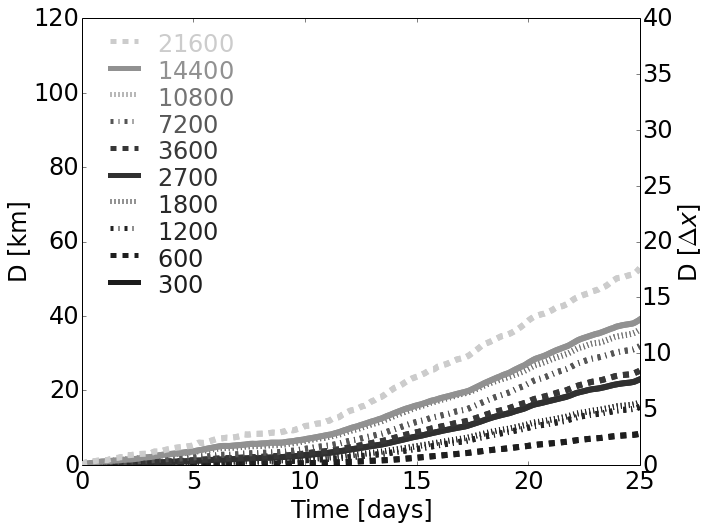

In [10]:
# Calculate dispersion between different particles starting at the same location
fig = figure(figsize(10,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
dx = 3

D9km_orig = np.zeros(len(T), dtype=int) # time index when D passes 9 km
for i, File in enumerate(FilesC_orig):
    File = File[:-3] + 'Dcomp.npz'
    
    if '300' in File:
        continue
    
    # Read in numerical dispersion values calculated previously on hafen
    d = load(File)
    D2 = d['D2']; t = d['t'];
    days = (t-t[0])/(3600*24)
    tseas = float(File.split('tseas_use')[1].split('_')[0])/60. # model output sampling time in minutes
    if D2.max()>=9:# When is distance about 3 grid cells apart?     
        D9km_orig[i] = find(D2>=9)[0]
        
    cind = find(mins==tseas) # find index in plotting arrays for this simulation
    
    ax1.plot(days[:], D2[:], color=cols[cind], linewidth=6, linestyle=ms[cind], label=mins[cind])
    ax2.plot(days[:], D2[:]/dx, color=cols[cind], linewidth=6, linestyle=ms[cind], label=None)

# Make right side y ticks also for looking at grid resolution
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('D [km]')
ylims = ax1.set_ylim(0,120.)
ylims = ax1.get_ylim()
ax2.set_ylim(ylims[0]/dx, ylims[1]/dx)
ax2.set_ylabel('D [$\Delta x$]')

# legend
for i, value in enumerate(T):
    text(0.135, 0.326+0.06*(i+1), '$' + "%.0f" % value + '$', color=cols[i], transform = ax1.transAxes, 
         fontsize=24, family='monospace')
    plot([0.05,0.1], [0.35+0.06*(i+1),0.35+0.06*(i+1)], linestyle=ms[i], color=cols[i], 
         linewidth=5, transform = ax1.transAxes)

savefig('figures/D_numerical25days.png', bbox_inches='tight')
savefig('figures/D_numerical25days.pdf', bbox_inches='tight')


## Test Case

We have nondimensionalized the results above along the way so that they may pertain to other situations. We test this by running the drifters at a different horizontal location and evaluating the resulting metrics.

### Metrics for numerical error

In [11]:
FilesC_test = ['/Volumes/Emmons/projects/time_res/calcs/test/tseas_use300_nsteps1.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use600_nsteps2.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use1200_nsteps4.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use1800_nsteps6.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use2700_nsteps9.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use3600_nsteps12.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use7200_nsteps24.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use10800_nsteps36.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use14400_nsteps48.nc',
         '/Volumes/Emmons/projects/time_res/calcs/test/tseas_use21600_nsteps72.nc']

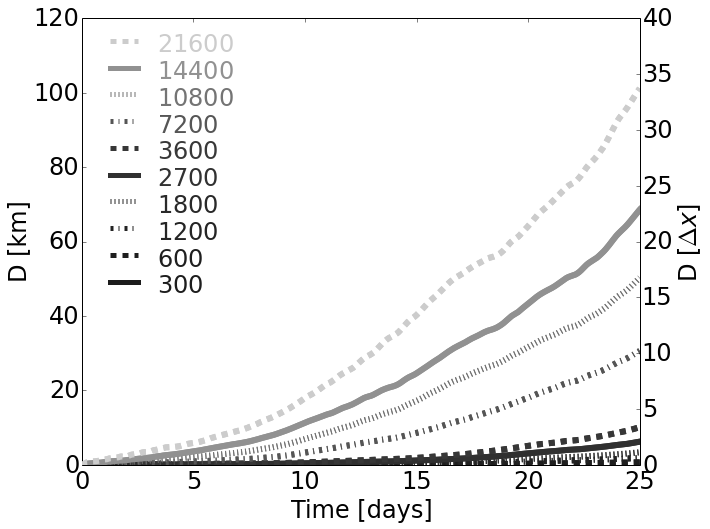

In [12]:
# Calculate dispersion between different particles starting at the same location
fig = figure(figsize(10,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
dx = 3
      
D9km_test = np.zeros(len(T), dtype=int) # time index when D passes 15 km
for i, File in enumerate(FilesC_test):
    
    if '300' in File:
        continue
        
    File = File[:-3] + 'Dcomp.npz'

    # Read in numerical dispersion values calculated previously on hafen
    d = load(File)
    D2 = d['D2']; t = d['t'];
    days = (t-t[0])/(3600*24)
    tseas = float(File.split('tseas_use')[1].split('_')[0])/60. # model output sampling time in minutes
    if D2.max()>=9: # When is distance about 3 grid cells apart?
        D9km_test[i] = find(D2>=9)[0]
    cind = find(mins==tseas) # find index in plotting arrays for this simulation

    ax1.plot(days[:], D2[:], color=cols[cind], linewidth=6, linestyle=ms[cind], label=mins[cind])
    ax2.plot(days[:], D2[:]/dx, color=cols[cind], linewidth=6, linestyle=ms[cind], label=None)


# Make right side y ticks also for looking at grid resolution
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('D [km]')
ylims = ax1.set_ylim(0,120.)
ax2.set_ylim(ylims[0]/dx, ylims[1]/dx)
ax2.set_ylabel('D [$\Delta x$]')

# legend
for i, value in enumerate(T):
    text(0.135, 0.326+0.06*(i+1), '$' + "%.0f" % value + '$', color=cols[i], transform = ax1.transAxes, 
         fontsize=24, family='monospace')
    plot([0.05,0.1], [0.35+0.06*(i+1),0.35+0.06*(i+1)], linestyle=ms[i], color=cols[i], 
         linewidth=5, transform = ax1.transAxes)

savefig('figures/test/D_numerical25days.png', bbox_inches='tight')
savefig('figures/test/D_numerical25days.pdf', bbox_inches='tight')


## 4th Case

In [13]:
FilesC_4th = ['/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use300_nsteps1.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use600_nsteps2.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use1200_nsteps4.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use1800_nsteps6.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use2700_nsteps9.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use3600_nsteps12.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use7200_nsteps24.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use10800_nsteps36.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use14400_nsteps48.nc',
         '/Volumes/Emmons/projects/time_res/calcs/4th/tseas_use21600_nsteps72.nc']

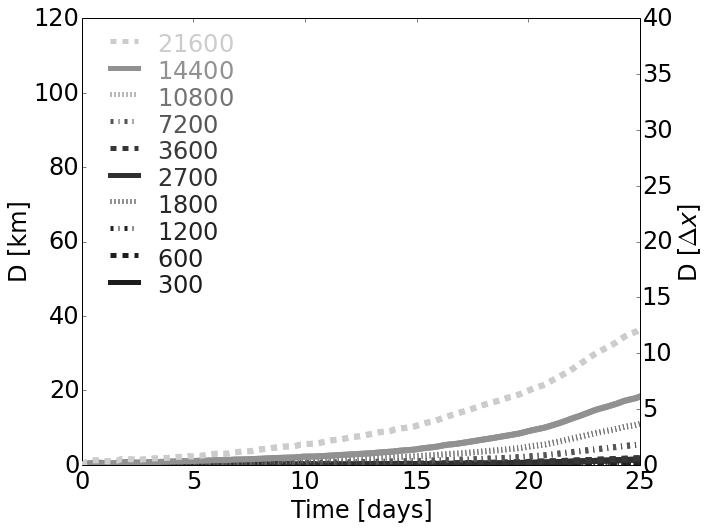

In [14]:
# Calculate dispersion between different particles starting at the same location
fig = figure(figsize(10,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
dx = 3

D9km_4th = np.zeros(len(T), dtype=int) # time index when D passes 15 km
for i, File in enumerate(FilesC_4th):
    
    if '300' in File:
        continue
    File = File[:-3] + 'Dcomp.npz'

    # Read in numerical dispersion values calculated previously on hafen
    d = load(File)
    D2 = d['D2']; t = d['t'];
    days = (t-t[0])/(3600*24)
    tseas = float(File.split('tseas_use')[1].split('_')[0])/60. # model output sampling time in minutes
    if D2.max()>=9: # When is distance about 5 grid cells apart?
        D9km_4th[i] = find(D2>=9)[0]
    cind = find(mins==tseas) # find index in plotting arrays for this simulation
    
    ax1.plot(days[:], D2[:], color=cols[cind], linewidth=6, linestyle=ms[cind], label=mins[cind])
    ax2.plot(days[:], D2[:]/dx, color=cols[cind], linewidth=6, linestyle=ms[cind], label=None)


# Make right side y ticks also for looking at grid resolution
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('D [km]')
ylims = ax1.set_ylim(0,120.)
ax2.set_ylim(ylims[0]/dx, ylims[1]/dx)
ax2.set_ylabel('D [$\Delta x$]')

# legend
for i, value in enumerate(T):
    text(0.135, 0.326+0.06*(i+1), '$' + "%.0f" % value + '$', color=cols[i], transform = ax1.transAxes, 
         fontsize=24, family='monospace')
    plot([0.05,0.1], [0.35+0.06*(i+1),0.35+0.06*(i+1)], linestyle=ms[i], color=cols[i], 
         linewidth=5, transform = ax1.transAxes)

savefig('figures/4th/D_numerical25days.png', bbox_inches='tight')
savefig('figures/4th/D_numerical25days.pdf', bbox_inches='tight')


# Metrics by number of days to basic separation

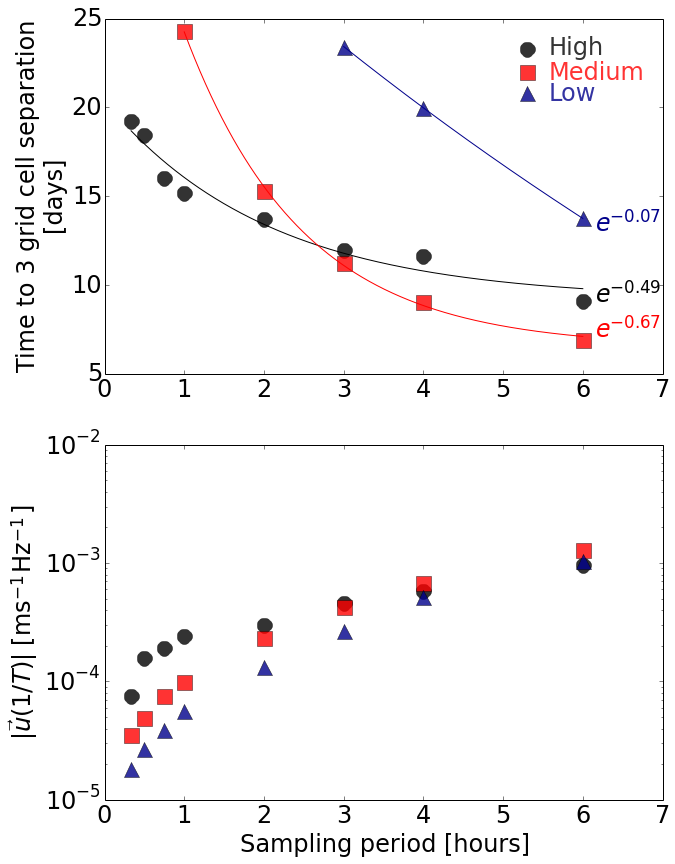

In [15]:
Thours = T/3600.
x = linspace(Thours.min(),Thours.max(),1000)

# Original case
Ddays_orig = days[D9km_orig] 
ind = Ddays_orig!=0

def fDdays_orige(tend, a, b, c):
    return a*exp(-b*tend)+c

popt_Ddays_orige, pcov = curve_fit(fDdays_orige, Thours[ind], Ddays_orig[ind])
x = linspace(Thours[ind].min(),Thours[ind].max(),1000)
fig = figure(figsize=(10,14))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(Thours[ind], Ddays_orig[ind], 'o', color='k', markersize=15, alpha=0.8)
ax1.plot(x, fDdays_orige(x,*popt_Ddays_orige), 'k')

# Test case
Ddays_test = days[D9km_test] 
ind = Ddays_test!=0

def fDdays_teste(tend, a, b, c):
    return a*exp(-b*tend)+c

popt_Ddays_teste, pcov = curve_fit(fDdays_teste, Thours[ind], Ddays_test[ind])
x = linspace(Thours[ind].min(),Thours[ind].max(),1000)
ax1.plot(Thours[ind], Ddays_test[ind], 's', color='r', markersize=15, alpha=0.8)
ax1.plot(x, fDdays_teste(x,*popt_Ddays_teste), 'r')

# 4th case
Ddays_4th = days[D9km_4th] 
ind = Ddays_4th!=0

def fDdays_4the(tend, a, b, c):
    return a*exp(-b*tend)+c

popt_Ddays_4the, pcov = curve_fit(fDdays_4the, Thours[ind], Ddays_4th[ind])
x = linspace(Thours[ind].min(),Thours[ind].max(),1000)
ax1.plot(Thours[ind], Ddays_4th[ind], '^', color='darkblue', markersize=15, alpha=0.8)
ax1.plot(x, fDdays_4the(x,*popt_Ddays_4the), color='darkblue')

ax1.set_xlim(0,7)
ylabel('Time to 3 grid cell separation\n[days]')
ax2.set_xticklabels([])
plot(5.3, 23.3, 'o', color='k', alpha=0.8, markersize=15)
plot(5.3, 22, 's', color='r', alpha=0.8, markersize=15)
plot(5.3, 20.8, '^', color='darkblue', alpha=0.8, markersize=15)
text(0.8, 0.9, 'High', color='k', transform=ax1.transAxes, alpha=0.8, fontsize=24)
text(0.8, 0.83, 'Medium', color='r', transform=ax1.transAxes, alpha=0.8, fontsize=24)
text(0.8, 0.77, 'Low', color='darkblue', transform=ax1.transAxes, alpha=0.8, fontsize=24)

text(6.15, 9, '$e^' + '{-%.2f' % popt_Ddays_orige[1] + '}$', fontsize=24, color='k')
text(6.15, 7, '$e^' + '{-%.2f' % popt_Ddays_teste[1] + '}$', fontsize=24, color='r')
text(6.15, 13, '$e^' + '{-%.2f' % popt_Ddays_4the[1] + '}$', fontsize=24, color='darkblue')

ax2 = fig.add_subplot(2,1,2)
ax2.set_xlim(0,7)
ax2.semilogy(Thours[2:], U_orig[2:], 'ko', markersize=15, alpha=0.8)
ax2.semilogy(Thours[2:], U_test[2:], 'rs', markersize=15, alpha=0.8)
ax2.semilogy(Thours[2:], U_4th[2:], '^', color='darkblue', markersize=15, alpha=0.8)
ax2.set_xlabel('Sampling period [hours]'); 
ax2.set_ylabel(r'$|\vec{u}(1/T)|$ [ms$^{-1}$Hz$^{-1}]$')#, color='0.2')

savefig('figures/time_9km-wmag.png', bbox_inches='tight')
savefig('figures/time_9km-wmag.pdf', bbox_inches='tight')
